# Breakout Trading Strategy

The hypothesis for this strategy is the following:

- In the absence of news or significant investor trading interest, stocks oscillate in a range.
- Traders seek to capitalize on this range-bound behaviour periodically by selling/shorting at the top of the range and buying/covering at the bottom of the range. This behaviour reinforces the existence of the range.
- When stocks break out of the range, due to, e.g., a significant news release or from market pressure from a large investor:
>the liquidity traders who have been providing liquidity at the bounds of the range seek to cover their positions to mitigate losses, thus magnifying the move out of the range, and the move out of the range attracts other investor interest; these investors, due to the behavioural bias of herding (e.g., Herd Behavior) build positions which favor continuation of the trend.

## Import libraries

In [ ]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import requests
import bs4 as bs
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Load stock data

In [3]:
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'id': 'constituents'})
tickers = []

for row in table.find_all('tr')[1:]:
		ticker = row.find('td').text.strip()
		if "." in ticker:
			ticker = ticker.replace('.','-')
		tickers.append(ticker)

In [4]:
df = yf.download(tickers=tickers, period="max", interval="1d", group_by="ticker", auto_adjust=True)
df

[*********************100%***********************]  505 of 505 completed


CL                        ...         CVX                       
                 Open       High        Low  ...         Low       Close     Volume
Date                                         ...                                   
1962-01-02        NaN        NaN        NaN  ...    0.368748    0.374668   105840.0
1962-01-03        NaN        NaN        NaN  ...    0.372131    0.373823   127680.0
1962-01-04        NaN        NaN        NaN  ...    0.370440    0.370440    75600.0
1962-01-05        NaN        NaN        NaN  ...    0.361136    0.361136   201600.0
1962-01-08        NaN        NaN        NaN  ...    0.356908    0.359445   126000.0
...               ...        ...        ...  ...         ...         ...        ...
2021-08-05  78.769997  79.379997  78.400002  ...  100.669998  101.230003  7986100.0
2021-08-06  78.970001  79.250000  78.300003  ...  101.599998  101.949997  6474200.0
2021-08-09  78.769997  78.930000  78.029999  ...   99.930000  100.250000  9243100.0
2021-08-10  78.550003  78.769997  77.989998  ...  100.580002  102.080002  9761700.0
2021-08-11  78.580002  79.339996  78.580002  ...  101.599998  102.849998  7079000.0

[15007 rows x 2525 columns]

In [5]:
df = df.loc["2015-01-01":"2020-01-01",:]

## Get high, low, and close prices

In [6]:
close_df = df.copy()
close_df = close_df.loc[:, close_df.columns.get_level_values(1)=="Close"].fillna(method="ffill")
close_df.columns = close_df.columns.get_level_values(0)

In [7]:
high_df = df.copy()
high_df = high_df.loc[:, high_df.columns.get_level_values(1)=="High"].fillna(method="ffill")
high_df.columns = high_df.columns.get_level_values(0)

In [8]:
low_df = df.copy()
low_df = low_df.loc[:, low_df.columns.get_level_values(1)=="Low"].fillna(method="ffill")
low_df.columns = low_df.columns.get_level_values(0)

In [9]:
close_df

,CL,MAS,BDX,KHC,PCAR,NEE,DAL,WDC,LDOS,FMC,CF,DE,CSX,CAG,AZO,GE,LNC,TSLA,NWL,TTWO,GIS,MCHP,TROW,CDNS,AXP,CBOE,GL,WELL,XLNX,LH,KMB,EMR,SIVB,WMT,PSX,TFX,EMN,REGN,LOW,BRK-B,...,BWA,ILMN,BKNG,HBI,CTVA,SPGI,EVRG,DOV,HD,EQIX,MCD,IPG,MMM,LW,INFO,TDY,AFL,MDLZ,TRMB,INTC,O,HWM,SNA,DHR,LKQ,ABC,AEE,ITW,ED,PHM,HON,COST,AVY,TRV,AJG,COF,BXP,BBWI,NKE,CVX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,59.082150,20.272972,127.336792,NaN,54.014889,22.527336,44.267326,92.755753,27.289410,44.908512,45.062408,77.174118,10.704546,23.365509,616.789978,168.181656,48.761116,43.862000,30.293436,28.100000,41.970501,39.447235,68.773338,18.830000,83.763786,60.234638,51.254368,56.330090,38.451271,111.419998,93.946938,50.392914,115.129997,73.955322,57.471699,110.030579,63.617599,410.160004,60.199924,149.169998,...,49.613518,185.419998,1142.060059,22.593838,NaN,82.608414,33.227219,50.619854,89.220993,191.133575,78.301109,16.076792,136.070679,NaN,26.207640,102.160004,26.117201,32.353783,26.910000,30.287306,36.520172,34.551453,119.104225,62.678810,27.780001,81.201576,37.564613,81.353249,52.055309,19.331329,83.490555,119.908997,45.450176,90.508583,40.090446,72.935394,107.873436,51.857246,44.257999,84.587646
2015-01-05,58.645714,19.924417,128.119843,NaN,52.199848,22.288734,43.529236,91.529411,26.859257,43.923157,44.908348,75.522995,10.414913,23.111113,608.489990,165.094543,47.258015,42.018002,29.941353,27.620001,41.211842,38.568100,67.193527,18.400000,81.548584,62.154991,50.336407,57.025536,37.745739,112.389999,93.410309,49.357162,111.930000,73.740074,53.997475,107.612091,61.421593,412.470001,58.759399,147.000000,...,48.181484,190.720001,1097.579956,22.038239,NaN,81.145592,32.952812,48.854698,87.349121,189.168655,77.436325,15.616324,133.001923,NaN,25.577078,99.720001,25.433054,31.870111,26.030001,29.945772,37.271309,32.549725,116.963158,62.057274,27.440001,80.510384,37.188881,79.342598,51.560959,19.049452,81.899551,118.545715,44.888519,89.418404,39.851513,71.255447,108.851402,51.079838,43.545448,81.206558
2015-01-06,58.029560,19.900097,127.874008,NaN,52.271183,22.375305,42.503113,89.488342,26.808659,44.206947,45.837486,74.894020,9.999872,22.882805,607.820007,161.537643,45.746441,42.256001,29.421272,27.930000,41.109100,37.820831,66.006691,17.910000,79.810616,62.801468,49.655029,57.838093,37.198963,110.599998,92.507858,49.275608,108.290001,74.308296,52.486938,106.114967,61.163715,396.890015,58.892792,146.839996,...,47.846130,188.309998,1079.959961,21.680773,NaN,79.971596,32.855957,48.622631,87.081688,185.044983,77.579056,15.195545,131.583664,NaN,25.232243,98.019997,25.206434,31.650244,25.660000,29.387686,37.759556,32.789066,116.604858,61.633186,26.950001,80.950226,36.755978,78.251381,51.851288,18.822132,81.707947,120.112244,45.336082,88.620087,39.774708,69.929207,110.963501,50.555542,43.289291,81.168976
2015-01-07,58.491665,20.201120,130.869370,NaN,52.968674,22.580122,42.278084,90.832268,27.245132,44.538021,47.144447,74.570786,10.131251,23.424219,607.239990,161.604767,46.383339,42.189999,29.597307,28.100000,41.978397,38.031799,66.977013,18.420000,81.553696,63.866211,49.711815,58.372475,37.216599,112.540001,93.150162,49.169586,110.239998,76.279877,52.717487,106.949898,60.772778,407.720001,60.644527,148.880005,...,48.969994,194.919998,1069.569946,22.434509,NaN,81.033775,33.412849,49.023487,90.066376,185.652115,78.930824,15.592506,132.537476,NaN,26.089405,98.790001,25.364643,32.643990,25.340000,30.004089,38.375496,33.637619,117.338943,62.006088,27.330000,82.566002,37.041859,79.102043,52.620274,19.749596,82.299408,122.203659,45.783653,90.130882,40.158718,70.724930,112.204460,52.459877,44.183491,81.101357
2015-01-08,59.287544,21.006563,133.254822,NaN,53.666142,22.717365,43.376205,92.713745,27.321035,45.641617,47.799545,75.557938,10.292488,23.933022,606.000000,163.550980,47.448761,42.124001,30.285431,28.459999,42.663303,39.245029,67.770920,18.610001,82.709732,63.219765,50.478363,58.130913,38.045589,115.570000,95.117714,50.

## Compute highs & lows in specific window

The variable `lookback_days` contains the number of days to look in the past. Make sure this doesn't include the current day, hence `.shift(1)` 

In [10]:
def get_highs_lows_lookback(high_df, low_df, lookback_days):
  """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
  """

  lookback_high = high_df.shift(1).rolling(window=lookback_days).max()
  lookback_low = low_df.shift(1).rolling(window=lookback_days).min()

  return (lookback_high, lookback_low)

In [11]:
lookback_days = 63
lookback_highs, lookback_lows = get_highs_lows_lookback(high_df, low_df, lookback_days)

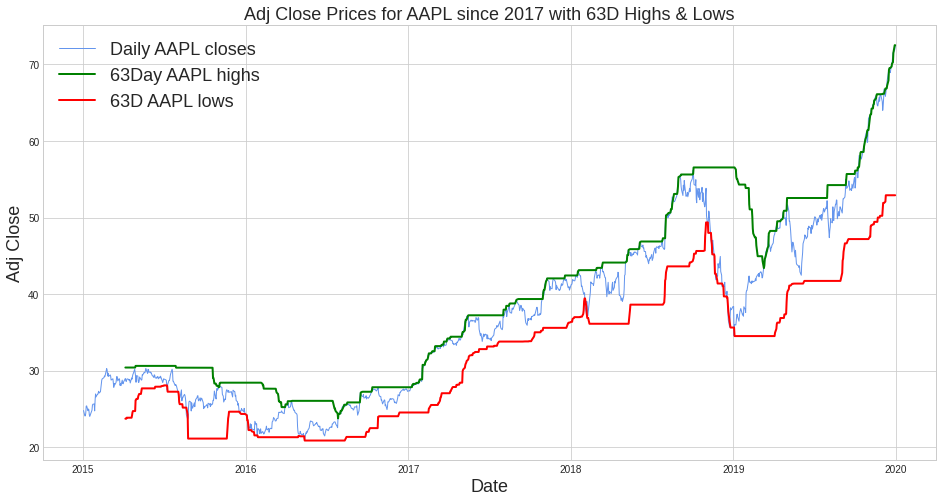

In [12]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc[:,"AAPL"], alpha=1.0, label="Daily AAPL closes", linewidth=1, color="cornflowerblue", zorder=1)
plt.plot(lookback_highs.loc[:,"AAPL"], alpha=1.0, label="{}Day AAPL highs".format(lookback_days), linewidth=2, color="green", zorder=2)
plt.plot(lookback_lows.loc[:,"AAPL"], alpha=1.0, label="{}D AAPL lows".format(lookback_days), linewidth=2, color="red", zorder=3)
plt.legend(fontsize=18)
plt.title("Adj Close Prices for AAPL since 2017 with {}D Highs & Lows".format(lookback_days), fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Compute long and short signals (market entry signals)

- Short when Close < Low
- Long when Close > High
- Neutral otherwise

In [13]:
def get_long_short(close, lookback_high, lookback_low):
  """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
  """

  # create initial long/short signal dataframe with all zeros
  long_short = (close*0).fillna(0).astype(np.int)
  # create long signals when close > high
  long_signals = (close > lookback_high).astype(np.int)
  # create short signals when close < low
  short_signals = (close < lookback_low).astype(np.int)
  # combine both long and short signals
  long_short = long_short + long_signals - short_signals

  return long_short

In [14]:
signal = get_long_short(close_df, lookback_highs, lookback_lows)
signal

,CL,MAS,BDX,KHC,PCAR,NEE,DAL,WDC,LDOS,FMC,CF,DE,CSX,CAG,AZO,GE,LNC,TSLA,NWL,TTWO,GIS,MCHP,TROW,CDNS,AXP,CBOE,GL,WELL,XLNX,LH,KMB,EMR,SIVB,WMT,PSX,TFX,EMN,REGN,LOW,BRK-B,...,BWA,ILMN,BKNG,HBI,CTVA,SPGI,EVRG,DOV,HD,EQIX,MCD,IPG,MMM,LW,INFO,TDY,AFL,MDLZ,TRMB,INTC,O,HWM,SNA,DHR,LKQ,ABC,AEE,ITW,ED,PHM,HON,COST,AVY,TRV,AJG,COF,BXP,BBWI,NKE,CVX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Filter signals

Filter out repeated long or short signals within the lookahead_days. If the previous signal was the same (within that window), change the signal to 0 (do nothing signal).

In [15]:
def clear_signals(signals, window_size):
  """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    clean_signals : Pandas Series
        Signals with the signals removed from the window size  
  """
  # Start with buffer of window size
  # This handles the edge case of calculating past_signal in the beginning
  clean_signals = [0]*window_size
    
  for signal_i, current_signal in enumerate(signals):
    # Check if there was a signal in the past window_size of days
    has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
    # Use the current signal if there's no past signal, else 0/False
    clean_signals.append(not has_past_signal and current_signal)
        
  # Remove buffer
  clean_signals = clean_signals[window_size:]

  # Return the signals as a Series of Ints
  return pd.Series(np.array(clean_signals).astype(np.int), signals.index)

In [16]:
def filter_signals(signal, lookahead_days):
  """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
  """

  long_signals = (signal == 1).astype(np.int)
  short_signals = (signal == -1).astype(np.int)

  for ticker in signal.columns:
    long_signals.loc[:, ticker] = clear_signals(long_signals.loc[:, ticker], lookahead_days)
    short_signals.loc[:, ticker] = clear_signals(short_signals.loc[:, ticker], lookahead_days)

  filtered_signal = long_signals - short_signals

  return filtered_signal

In [17]:
signal_1 = filter_signals(signal, lookahead_days=1)
signal_10 = filter_signals(signal, lookahead_days=5)
signal_20 = filter_signals(signal, lookahead_days=10)
signal_50 = filter_signals(signal, lookahead_days=20)

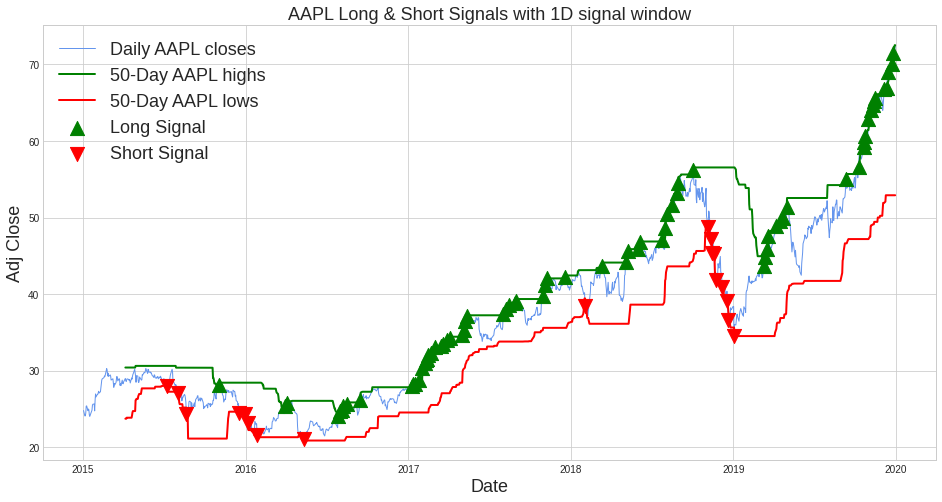

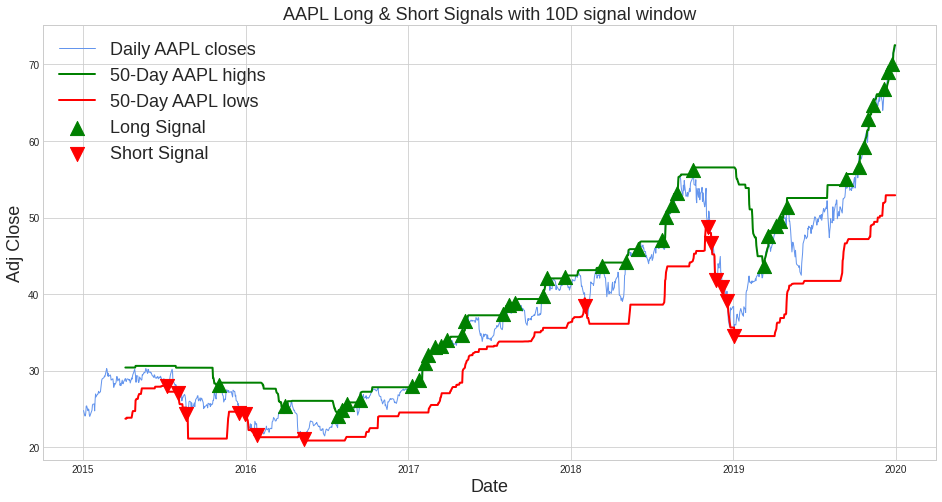

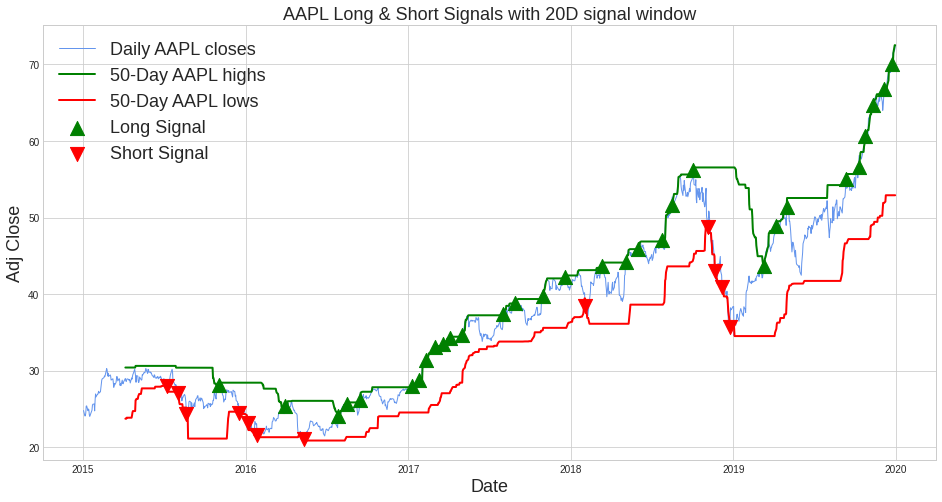

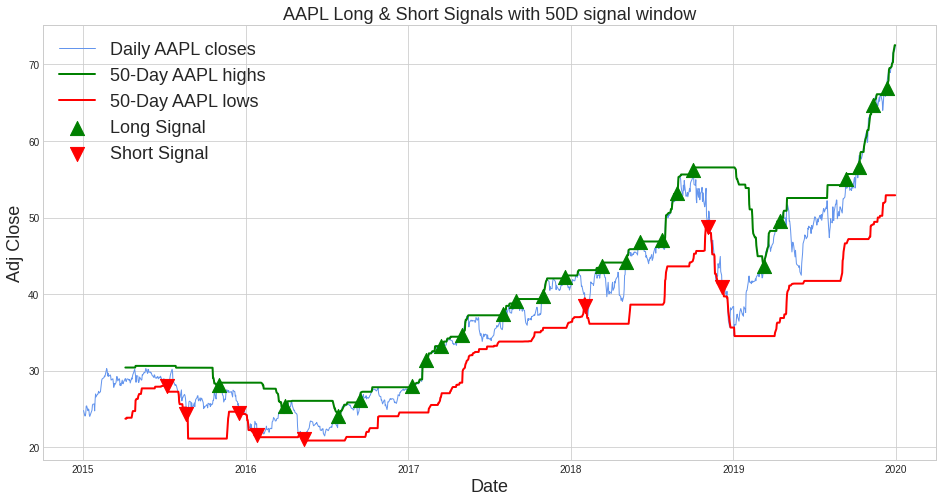

In [18]:
for signal_data, signal_days in [(signal_1, 1), (signal_10, 10), (signal_20, 20), (signal_50, 50)]:

  plt.figure(figsize=(16,8))
  plt.plot(close_df.loc[:,"AAPL"], alpha=1.0, label="Daily AAPL closes", linewidth=1, color="cornflowerblue", zorder=1)
  plt.plot(lookback_highs.loc[:,"AAPL"], alpha=1.0, label="50-Day AAPL highs", linewidth=2, color="green", zorder=2)
  plt.plot(lookback_lows.loc[:,"AAPL"], alpha=1.0, label="50-Day AAPL lows", linewidth=2, color="red", zorder=3)
  plt.scatter(signal_data.index, np.where(signal_data.loc[:, "AAPL"]==1, close_df.loc[:, "AAPL"], np.nan), alpha=1, label="Long Signal", marker="^", color="green", s=200, zorder=4)
  plt.scatter(signal_data.index, np.where(signal_data.loc[:, "AAPL"]==-1, close_df.loc[:, "AAPL"], np.nan), alpha=1, label="Short Signal", marker="v", color="red", s=200, zorder=5)
  plt.legend(fontsize=18)
  plt.title("AAPL Long & Short Signals with {}D signal window".format(signal_days), fontsize=18)
  plt.xlabel("Date", fontsize=18)
  plt.ylabel("Adj Close", fontsize=18)
  plt.show()

## Lookahead close prices

With the trading signal done, we can start working on evaluating how many days to short or long the stocks. In this problem, implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`.

In [19]:
def get_lookahead_prices(close, lookahead_days):
  """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
  """

  lookahead_prices = close.shift(-lookahead_days)
  return lookahead_prices

In [20]:
lookahead_1 = get_lookahead_prices(close_df, 1)
lookahead_10 = get_lookahead_prices(close_df, 10)
lookahead_20 = get_lookahead_prices(close_df, 20)
lookahead_50 = get_lookahead_prices(close_df, 50)

In [21]:
lookahead_1

,CL,MAS,BDX,KHC,PCAR,NEE,DAL,WDC,LDOS,FMC,CF,DE,CSX,CAG,AZO,GE,LNC,TSLA,NWL,TTWO,GIS,MCHP,TROW,CDNS,AXP,CBOE,GL,WELL,XLNX,LH,KMB,EMR,SIVB,WMT,PSX,TFX,EMN,REGN,LOW,BRK-B,...,BWA,ILMN,BKNG,HBI,CTVA,SPGI,EVRG,DOV,HD,EQIX,MCD,IPG,MMM,LW,INFO,TDY,AFL,MDLZ,TRMB,INTC,O,HWM,SNA,DHR,LKQ,ABC,AEE,ITW,ED,PHM,HON,COST,AVY,TRV,AJG,COF,BXP,BBWI,NKE,CVX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,58.645714,19.924417,128.119843,NaN,52.199848,22.288734,43.529236,91.529411,26.859257,43.923157,44.908348,75.522995,10.414913,23.111113,608.489990,165.094543,47.258015,42.018002,29.941353,27.620001,41.211842,38.568100,67.193527,18.400000,81.548584,62.154991,50.336407,57.025536,37.745739,112.389999,93.410309,49.357162,111.930000,73.740074,53.997475,107.612091,61.421593,412.470001,58.759399,147.000000,...,48.181484,190.720001,1097.579956,22.038239,NaN,81.145592,32.952812,48.854698,87.349121,189.168655,77.436325,15.616324,133.001923,NaN,25.577078,99.720001,25.433054,31.870111,26.030001,29.945772,37.271309,32.549725,116.963158,62.057274,27.440001,80.510384,37.188881,79.342598,51.560959,19.049452,81.899551,118.545715,44.888519,89.418404,39.851513,71.255447,108.851402,51.079838,43.545448,81.206558
2015-01-05,58.029560,19.900097,127.874008,NaN,52.271183,22.375305,42.503113,89.488342,26.808659,44.206947,45.837486,74.894020,9.999872,22.882805,607.820007,161.537643,45.746441,42.256001,29.421272,27.930000,41.109100,37.820831,66.006691,17.910000,79.810616,62.801468,49.655029,57.838093,37.198963,110.599998,92.507858,49.275608,108.290001,74.308296,52.486938,106.114967,61.163715,396.890015,58.892792,146.839996,...,47.846130,188.309998,1079.959961,21.680773,NaN,79.971596,32.855957,48.622631,87.081688,185.044983,77.579056,15.195545,131.583664,NaN,25.232243,98.019997,25.206434,31.650244,25.660000,29.387686,37.759556,32.789066,116.604858,61.633186,26.950001,80.950226,36.755978,78.251381,51.851288,18.822132,81.707947,120.112244,45.336082,88.620087,39.774708,69.929207,110.963501,50.555542,43.289291,81.168976
2015-01-06,58.491665,20.201120,130.869370,NaN,52.968674,22.580122,42.278084,90.832268,27.245132,44.538021,47.144447,74.570786,10.131251,23.424219,607.239990,161.604767,46.383339,42.189999,29.597307,28.100000,41.978397,38.031799,66.977013,18.420000,81.553696,63.866211,49.711815,58.372475,37.216599,112.540001,93.150162,49.169586,110.239998,76.279877,52.717487,106.949898,60.772778,407.720001,60.644527,148.880005,...,48.969994,194.919998,1069.569946,22.434509,NaN,81.033775,33.412849,49.023487,90.066376,185.652115,78.930824,15.592506,132.537476,NaN,26.089405,98.790001,25.364643,32.643990,25.340000,30.004089,38.375496,33.637619,117.338943,62.006088,27.330000,82.566002,37.041859,79.102043,52.620274,19.749596,82.299408,122.203659,45.783653,90.130882,40.158718,70.724930,112.204460,52.459877,44.183491,81.101357
2015-01-07,59.287544,21.006563,133.254822,NaN,53.666142,22.717365,43.376205,92.713745,27.321035,45.641617,47.799545,75.557938,10.292488,23.933022,606.000000,163.550980,47.448761,42.124001,30.285431,28.459999,42.663303,39.245029,67.770920,18.610001,82.709732,63.219765,50.478363,58.130913,38.045589,115.570000,95.117714,50.458157,113.279999,77.889839,54.768635,107.506516,62.652691,403.250000,61.925011,151.369995,...,49.803844,196.820007,1082.849976,22.861427,NaN,81.760521,33.711468,50.022106,92.059029,187.869965,79.224670,16.314964,135.714035,NaN,26.552477,100.440002,25.612640,33.057320,25.670000,30.562191,37.361454,34.594963,120.013100,62.963982,27.620001,82.754509,37.172543,81.009560,52.949837,20.358816,83.798752,123.253700,47.143909,92.002174,40.858467,71.414589,112.656487,52.236904,45.203430,82.957199
2015-01-08,58.705612,20.648588,131.679718,NaN,51.700527,22.516771,42.197063,94.259247,26.802328,45.357838,48.188709,74.824127,10.271588,23.639482,606.020020,161.269226,46.332211,41.332001,29.965374,27.870001,42.233238,39.139538,67.257713,18.549999,81.662071,62.744415,49.749672,58.189457,38.010315,116.000000,94.264023,49.

## Lookahead log returns

In [22]:
def get_lookahead_log_returns(close, lookahead_prices):
  """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_log_returns : DataFrame
        The lookahead log returns for each ticker and date
  """

  lookahead_log_returns = np.log(lookahead_prices/close)
  return lookahead_log_returns

In [23]:
price_log_return_1 = get_lookahead_log_returns(close_df, lookahead_1)
price_log_return_10 = get_lookahead_log_returns(close_df, lookahead_10)
price_log_return_20 = get_lookahead_log_returns(close_df, lookahead_20)
price_log_return_50 = get_lookahead_log_returns(close_df, lookahead_50)

In [24]:
price_log_return_1

,CL,MAS,BDX,KHC,PCAR,NEE,DAL,WDC,LDOS,FMC,CF,DE,CSX,CAG,AZO,GE,LNC,TSLA,NWL,TTWO,GIS,MCHP,TROW,CDNS,AXP,CBOE,GL,WELL,XLNX,LH,KMB,EMR,SIVB,WMT,PSX,TFX,EMN,REGN,LOW,BRK-B,...,BWA,ILMN,BKNG,HBI,CTVA,SPGI,EVRG,DOV,HD,EQIX,MCD,IPG,MMM,LW,INFO,TDY,AFL,MDLZ,TRMB,INTC,O,HWM,SNA,DHR,LKQ,ABC,AEE,ITW,ED,PHM,HON,COST,AVY,TRV,AJG,COF,BXP,BBWI,NKE,CVX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.007414,-0.017343,0.006131,NaN,-0.034180,-0.010648,-0.016814,-0.013309,-0.015888,-0.022186,-0.003425,-0.021627,-0.027430,-0.010947,-0.013548,-0.018526,-0.031311,-0.042950,-0.011690,-0.017229,-0.018241,-0.022538,-0.023239,-0.023101,-0.026802,0.031384,-0.018072,0.012270,-0.018519,0.008668,-0.005728,-0.020768,-0.028188,-0.002915,-0.062355,-0.022225,-0.035129,0.005616,-0.024220,-0.014654,...,-0.029289,0.028183,-0.039726,-0.024898,NaN,-0.017867,-0.008293,-0.035493,-0.021203,-0.010334,-0.011106,-0.029060,-0.022811,NaN,-0.024354,-0.024174,-0.026544,-0.015062,-0.033248,-0.011341,0.020359,-0.059681,-0.018140,-0.009966,-0.012315,-0.008548,-0.010053,-0.025026,-0.009542,-0.014689,-0.019240,-0.011434,-0.012435,-0.012118,-0.005978,-0.023303,0.009025,-0.015105,-0.016231,-0.040792
2015-01-05,-0.010562,-0.001221,-0.001921,NaN,0.001366,0.003877,-0.023855,-0.022552,-0.001886,0.006440,0.020479,-0.008363,-0.040666,-0.009928,-0.001102,-0.021780,-0.032508,0.005648,-0.017523,0.011161,-0.002496,-0.019565,-0.017821,-0.026991,-0.021542,0.010347,-0.013629,0.014148,-0.014592,-0.016055,-0.009708,-0.001654,-0.033061,0.007676,-0.028373,-0.014010,-0.004207,-0.038504,0.002268,-0.001089,...,-0.006985,-0.012717,-0.016184,-0.016353,NaN,-0.014573,-0.002944,-0.004761,-0.003066,-0.022040,0.001842,-0.027314,-0.010721,NaN,-0.013574,-0.017195,-0.008950,-0.006923,-0.014316,-0.018812,0.013015,0.007326,-0.003068,-0.006857,-0.018018,0.005448,-0.011709,-0.013849,0.005615,-0.012005,-0.002342,0.013128,0.009921,-0.008968,-0.001929,-0.018788,0.019218,-0.010317,-0.005900,-0.000463
2015-01-06,0.007932,0.015013,0.023154,NaN,0.013255,0.009112,-0.005308,0.014906,0.016150,0.007461,0.028114,-0.004325,0.013053,0.023385,-0.000955,0.000415,0.013826,-0.001563,0.005965,0.006068,0.020926,0.005563,0.014593,0.028078,0.021605,0.016812,0.001143,0.009197,0.000474,0.017389,0.006919,-0.002154,0.017847,0.026187,0.004383,0.007837,-0.006412,0.026921,0.029311,0.013797,...,0.023217,0.034500,-0.009667,0.034175,NaN,0.013195,0.016807,0.008210,0.033700,0.003276,0.017274,0.025788,0.007223,NaN,0.033407,0.007825,0.006257,0.030915,-0.012549,0.020758,0.016181,0.025550,0.006276,0.006032,0.014002,0.019764,0.007748,0.010812,0.014722,0.048100,0.007213,0.017262,0.009824,0.016904,0.009608,0.011315,0.011121,0.036976,0.020446,-0.000833
2015-01-07,0.013515,0.039097,0.018064,NaN,0.013082,0.006060,0.025642,0.020502,0.002782,0.024477,0.013800,0.013151,0.015789,0.021489,-0.002044,0.011971,0.022710,-0.001566,0.022983,0.012730,0.016184,0.031402,0.011784,0.010262,0.014076,-0.010173,0.015302,-0.004147,0.022030,0.026568,0.020902,0.025869,0.027203,0.020886,0.038170,0.005191,0.030465,-0.011024,0.020895,0.016586,...,0.016884,0.009700,0.012340,0.018851,NaN,0.008928,0.008898,0.020166,0.021883,0.011875,0.003716,0.045292,0.023685,NaN,0.017594,0.016564,0.009730,0.012582,0.012939,0.018430,-0.026780,0.028063,0.022534,0.015330,0.010555,0.002281,0.003522,0.023828,0.006244,0.030381,0.018054,0.008556,0.029278,0.020549,0.017275,0.009704,0.004021,-0.004259,0.022822,0.022625
2015-01-08,-0.009864,-0.017188,-0.011891,NaN,-0.037314,-0.008869,-0.027560,0.016532,-0.019168,-0.006237,0.008109,-0.009759,-0.002033,-0.012341,0.000033,-0.014050,-0.023813,-0.018981,-0.010624,-0.020949,-0.010132,-0.002692,-0.007601,-0.003229,-0.012748,-0.007547,-0.014541,0.001007,-0.000928,0.003714,-0.009016,-0.015802,-0.030565,-0.012458,-0.023202,-0.003398,-0.011752,0.019134,-0.018990,-0.012631,...,-0.026368,-0.010316,-0.028941,-0.003491,NaN,-0.008584,-0.014469,-0.021170,-0.017296,-0.026794,-0.012262,-0.012733,-0.012360,NaN,-0.004463,-0.004490

## Compute signal return

In [25]:
def get_signal_log_return(signal, lookahead_returns):
  """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_log_return : DataFrame
        Signal returns for each ticker and date
  """

  signal_log_return = signal*lookahead_returns
  return signal_log_return

In [26]:
signal_log_return_1 = get_signal_log_return(signal_1, price_log_return_1)
signal_log_return_10 = get_signal_log_return(signal_10, price_log_return_10)
signal_log_return_20 = get_signal_log_return(signal_20, price_log_return_20)
signal_log_return_50 = get_signal_log_return(signal_50, price_log_return_50)

In [27]:
signal_log_return_1

,CL,MAS,BDX,KHC,PCAR,NEE,DAL,WDC,LDOS,FMC,CF,DE,CSX,CAG,AZO,GE,LNC,TSLA,NWL,TTWO,GIS,MCHP,TROW,CDNS,AXP,CBOE,GL,WELL,XLNX,LH,KMB,EMR,SIVB,WMT,PSX,TFX,EMN,REGN,LOW,BRK-B,...,BWA,ILMN,BKNG,HBI,CTVA,SPGI,EVRG,DOV,HD,EQIX,MCD,IPG,MMM,LW,INFO,TDY,AFL,MDLZ,TRMB,INTC,O,HWM,SNA,DHR,LKQ,ABC,AEE,ITW,ED,PHM,HON,COST,AVY,TRV,AJG,COF,BXP,BBWI,NKE,CVX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.0,-0.000000,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.000000,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.00000,-0.0
2015-01-05,-0.0,-0.000000,-0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0000,-0.0,0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.000000,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.000000,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.00000,-0.0
2015-01-06,0.0,0.000000,0.0,NaN,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.000000,-0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,-0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.0
2015-01-07,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.00000,0.0
2015-01-08,-0.0,-0.000000,-0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.000000,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,0.000000,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.000000,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.00000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.0,0.000000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0000,-0.0,0.0,-0.0,0.000000,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.012447,0.0,-0.0,0.013104,0.0,-0.0,0.0,0.0,0.000000,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.000000,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.00000,0.0
2019-12-26,0.0,-0.000831,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0013,0.0,0.0,0.0,-0.004257,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,0.000000,0.0,0.0,-0.000000,0.0,0.0,-0.0,-0.0,0.000000,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.004337,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.000828,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.00000,-0.0
2019-12-27,-0.0,-0.000000,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,0.0,-0.0,-0.0,-0.003887,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.000000,0.0,-0.0,-

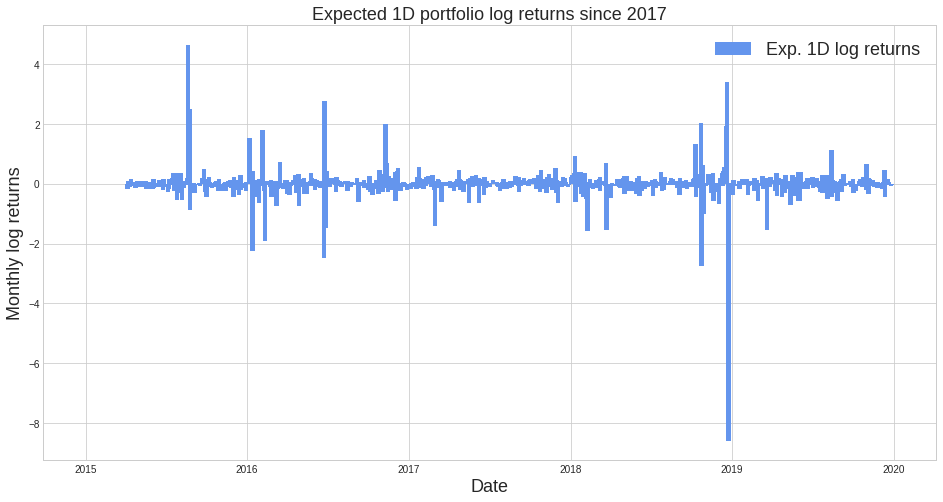

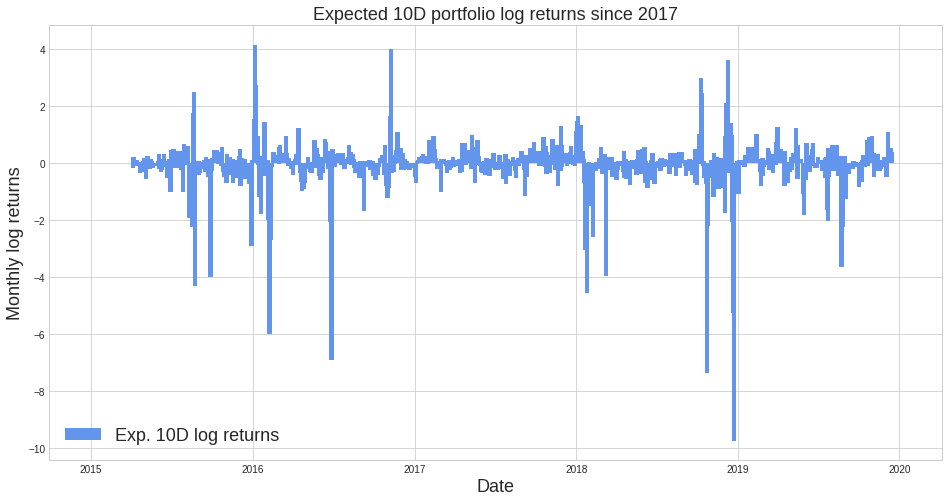

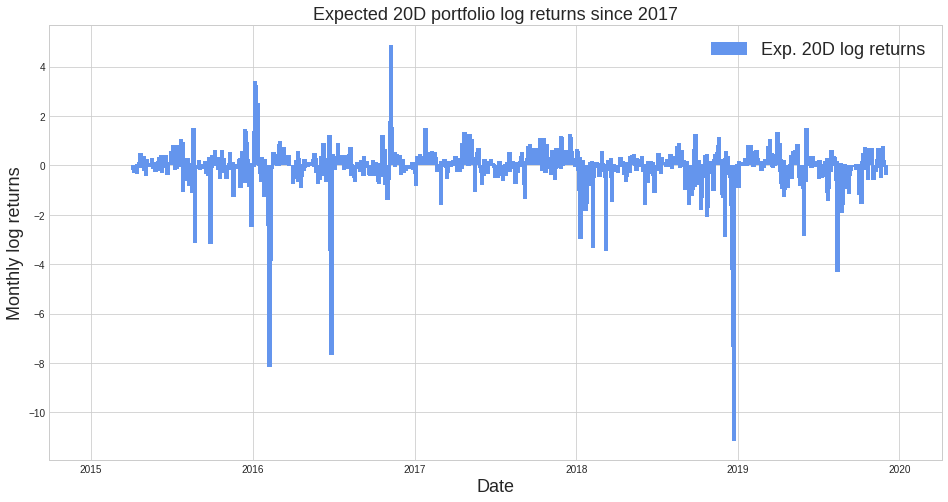

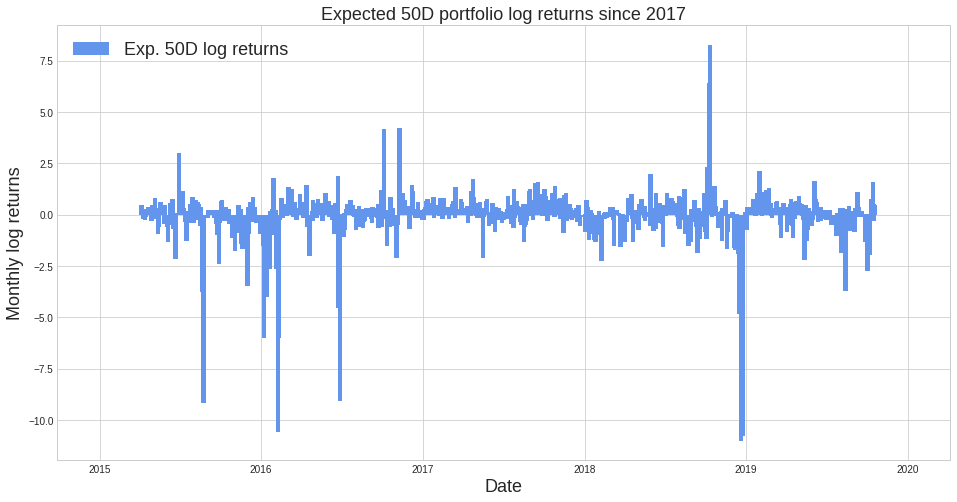

In [28]:
for signal_log_return, signal_days in [(signal_log_return_1, 1), (signal_log_return_10, 10), (signal_log_return_20, 20), (signal_log_return_50, 50)]:

  plt.figure(figsize=(16,8))
  plt.bar(signal_log_return.index, signal_log_return.sum(axis=1), alpha=1.0, label="Exp. {}D log returns".format(signal_days), width=10, color="cornflowerblue", zorder=1)
  plt.legend(fontsize=18)
  plt.title("Expected {}D portfolio log returns since 2017".format(signal_days), fontsize=18)
  plt.xlabel("Date", fontsize=18)
  plt.ylabel("Monthly log returns", fontsize=18)
  plt.show()

## Portfolio return histograms

In [ ]:
pip install colour

In [30]:
from colour import Color
import plotly as py
import plotly.offline as offline_py
import plotly.graph_objs as go

color_scheme = {
    'index': '#B6B2CF',
    'etf': '#2D3ECF',
    'tracking_error': '#6F91DE',
    'df_header': 'silver',
    'df_value': 'white',
    'df_line': 'silver',
    'heatmap_colorscale': [(0, '#6F91DE'), (0.5, 'grey'), (1, 'red')],
    'background_label': '#9dbdd5',
    'low_value': '#B6B2CF',
    'high_value': '#2D3ECF',
    'y_axis_2_text_color': 'grey',
    'shadow': 'rgba(0, 0, 0, 0.75)',
    'major_line': '#2D3ECF',
    'minor_line': '#B6B2CF',
    'main_line': 'black'}


def generate_config():
    return {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}

def plot_signal_histograms(signal_list, title, subplot_titles):
    assert len(signal_list) == len(subplot_titles)

    signal_series_list = [signal.stack() for signal in signal_list]
    all_values = pd.concat(signal_series_list)
    x_range = [all_values.min(), all_values.max()]
    y_range = [0, 1200]
    config = generate_config()
    colors = Color(color_scheme['low_value']).range_to(Color(color_scheme['high_value']), len(signal_series_list))

    fig = py.subplots.make_subplots(rows=1, cols=len(signal_series_list), subplot_titles=subplot_titles, print_grid=False)
    fig['layout'].update(title=title, showlegend=False)

    for series_i, (signal_series, color) in enumerate(zip(signal_series_list, colors), 1):
        filtered_series = signal_series[signal_series != 0].dropna()
        trace = go.Histogram(x=filtered_series, marker={'color': str(color)})
        fig.append_trace(trace, 1, series_i)
        fig['layout']['xaxis{}'.format(series_i)].update(range=x_range)
        fig['layout']['yaxis{}'.format(series_i)].update(range=y_range)

    offline_py.iplot(fig, config=config)

def plot_signal_to_normal_histograms(signal_list, title, subplot_titles):
    assert len(signal_list) == len(subplot_titles)

    signal_series_list = [signal.stack() for signal in signal_list]
    all_values = pd.concat(signal_series_list)
    x_range = [all_values.min(), all_values.max()]
    y_range = [0, 1200]
    config = generate_config()

    fig = py.subplots.make_subplots(rows=1, cols=len(signal_series_list), subplot_titles=subplot_titles, print_grid=False)
    fig['layout'].update(title=title)

    for series_i, signal_series in enumerate(signal_series_list, 1):
        filtered_series = signal_series[signal_series != 0].dropna()
        filtered_series_trace = go.Histogram(
            x=filtered_series,
            marker={'color': color_scheme['low_value']},
            name='Signal Return Distribution',
            showlegend=False)
        normal_trace = go.Histogram(
            x=np.random.normal(np.mean(filtered_series), np.std(filtered_series), len(filtered_series)),
            marker={'color': color_scheme['shadow']},
            name='Normal Distribution',
            showlegend=False)
        fig.append_trace(filtered_series_trace, 1, series_i)
        fig.append_trace(normal_trace, 1, series_i)
        fig['layout']['xaxis{}'.format(series_i)].update(range=x_range)
        fig['layout']['yaxis{}'.format(series_i)].update(range=y_range)

    # Show legened
    fig['data'][0]['showlegend'] = True
    fig['data'][1]['showlegend'] = True

    offline_py.iplot(fig, config=config)

In [31]:
plot_signal_histograms(
    [signal_log_return_1, signal_log_return_10, signal_log_return_20, signal_log_return_50],
    'Signal Return',
    ('1 Day', '10 Days', '20 Days', '50 Days'))

In [32]:
from scipy.stats import skew
from scipy.stats import kurtosis

stats_table = pd.DataFrame(data={"Stats":["Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

for signal_log_return, signal_days in [(signal_log_return_1, 1), (signal_log_return_10, 10), (signal_log_return_20, 20), (signal_log_return_50, 50)]:
    stats_table["{}D".format(signal_days)] = [signal_log_return.sum(axis=1).mean(),
                                              signal_log_return.sum(axis=1).median(),
                                              signal_log_return.sum(axis=1).max(),
                                              signal_log_return.sum(axis=1).min(), 
                                              signal_log_return.sum(axis=1).std(), 
                                              skew(signal_log_return.sum(axis=1)[1:]), 
                                              kurtosis(signal_log_return.sum(axis=1)[1:], fisher=True)]
stats_table

,1D,10D,20D,50D
Stats,,,,
Mean,-0.002006,-0.031339,-0.036757,-0.026139
Median,0.000000,0.000000,0.003029,0.008721
Max,4.626312,4.126767,4.868611,8.256759
Min,-8.581217,-9.733180,-11.135079,-11.006753
St. dev.,0.420074,0.736884,0.777280,1.019108
Skew,-5.176988,-4.372267,-5.126356,-4.162012
Kurtosis,159.686326,48.490925,59.795937,47.367784


To better visualize the outliers, let's compare the 5, 10, and 20 day signals returns to normal distributions with the same mean and deviation for each signal return distributions.

In [33]:
"""
plot_signal_to_normal_histograms(
    [signal_log_return_1, signal_log_return_10, signal_log_return_20, signal_log_return_50],
    'Signal Return',
    ('1 Day', '10 Days', '20 Days', '50 Days'))
"""

"\nplot_signal_to_normal_histograms(\n    [signal_log_return_1, signal_log_return_10, signal_log_return_20, signal_log_return_50],\n    'Signal Return',\n    ('1 Day', '10 Days', '20 Days', '50 Days'))\n"

## Kolgomorov-Smirnov Test

We need to find the stocks that are causing the outlying returns. We'll use the Kolmogorov-Smirnov Test or KS-Test between a distribution of stock returns (the input dataframe in this case) and each stock's signal returns. Run KS test on a normal distribution against each stock's signal returns.

In [34]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_1 = signal_log_return_1[signal_1 != 0].stack()
long_short_signal_returns_10 = signal_log_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_log_return_20[signal_20 != 0].stack()
long_short_signal_returns_50 = signal_log_return_50[signal_50 != 0].stack()

long_short_signal_returns_1

Date            
2015-04-06  DAL     0.002878
            CAG    -0.002105
            NWL    -0.012638
            BIO     0.000145
            ACN     0.007289
                      ...   
2019-12-27  K      -0.005509
            CPB    -0.004255
            EQIX   -0.003887
            NKE    -0.007610
2019-12-30  NEM    -0.006881
Length: 32444, dtype: float64

In [35]:
# Get just ticker and signal return
long_short_signal_returns_1 = long_short_signal_returns_1.reset_index().iloc[:, [1,2]]
long_short_signal_returns_1.columns = ['ticker', 'signal_return']

long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']

long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

long_short_signal_returns_50 = long_short_signal_returns_50.reset_index().iloc[:, [1,2]]
long_short_signal_returns_50.columns = ['ticker', 'signal_return']

long_short_signal_returns_1

,ticker,signal_return
0,DAL,0.002878
1,CAG,-0.002105
2,NWL,-0.012638
3,BIO,0.000145
4,ACN,0.007289
...,...,...
32439,K,-0.005509
32440,CPB,-0.004255
32441,EQIX,-0.003887
32442,NKE,-0.007610


In [36]:
def calculate_ks_test(long_short_signal_returns):
  """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
  """

  ks_values, p_values = [], []
  norm_args = (long_short_signal_returns.mean(), long_short_signal_returns.std(ddof=0))
  ks_test_df = long_short_signal_returns.groupby("ticker").signal_return.apply(lambda ser:stats.kstest(ser,'norm',norm_args))
    
  for ks, p in ks_test_df:
    ks_values.append(ks)
    p_values.append(p)
        
  ks_values = pd.Series(ks_values,index=ks_test_df.index)
  p_values = pd.Series(p_values,index=ks_test_df.index)
    
  return ks_values, p_values

In [37]:
ks_values_1, p_values_1 = calculate_ks_test(long_short_signal_returns_1)
ks_values_10, p_values_10 = calculate_ks_test(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_ks_test(long_short_signal_returns_20)
ks_values_50, p_values_50 = calculate_ks_test(long_short_signal_returns_50)

print('ks_values_1')
print(ks_values_1.head(10))
print('p_values_1')
print(p_values_1.head(10))

ks_values_1
ticker
A       0.210137
AAL     0.071702
AAP     0.138406
AAPL    0.175265
ABBV    0.158013
ABC     0.135350
ABMD    0.170657
ABT     0.174218
ACN     0.263653
ADBE    0.164669
dtype: float64
p_values_1
ticker
A       0.001541
AAL     0.955709
AAP     0.175873
AAPL    0.006885
ABBV    0.094009
ABC     0.303651
ABMD    0.020979
ABT     0.025008
ACN     0.000019
ADBE    0.020664
dtype: float64


## Find outliers

With the ks and p values calculate, let's find which symbols are the outliers. Find symbols that

- pass the null hypothesis with a p-value less than `pvalue_threshold` 
- have a KS value above `ks_threshold`.

In [38]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    ks_outliers = ks_values[ks_values > ks_threshold]
    pvalue_outliers = p_values[p_values < pvalue_threshold]
    
    ks_outliers = set(ks_outliers.index.values)
    pvalue_outliers = set(pvalue_outliers.index.values)
    
    return ks_outliers.intersection(pvalue_outliers)

In [39]:
ks_threshold = 0.2
outliers_1 = find_outliers(ks_values_1, p_values_1, ks_threshold)
outliers_10 = find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)
outliers_50 = find_outliers(ks_values_50, p_values_50, ks_threshold)

outlier_tickers = outliers_1.union(outliers_10).union(outliers_20).union(outliers_50)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

199 Outliers Found:
FIS, CL, CPRT, AMAT, BDX, OMC, FTV, NVR, NEE, SRE, APH, ALGN, AME, CSCO, CLX, SO, GPC, PAYX, NRG, KO, DE, LRCX, PG, AZO, GOOGL, MKC, MSI, LNC, TSLA, TTWO, EOG, GIS, NOC, TROW, CDNS, LNT, AMZN, BMY, WELL, ESS, NLSN, TMO, DUK, HSY, WMT, RE, URI, DTE, HIG, QCOM, AAL, MA, BR, SPG, FCX, BRK-B, SYY, CCI, DGX, ORCL, AVB, PFE, MCO, EL, NDAQ, SWK, HUM, NFLX, STX, WRB, CMS, AWK, TMUS, FRT, AMCR, VRSK, GLW, BIO, PEP, XYL, USB, HRL, NVDA, V, IDXX, MU, DXCM, TSN, APD, CB, PSA, WYNN, ALK, K, EQR, ES, SHW, DVN, FE, SJM, ICE, WEC, BIIB, CCL, GRMN, CTAS, VZ, AAPL, TYL, NI, GPN, PGR, ROL, IBM, ALL, ACN, HCA, ATO, CMG, FISV, APA, MDT, CTSH, POOL, L, AMD, BLL, ECL, RSG, FITB, LMT, UPS, TWTR, MRK, ADP, NXPI, ETR, BWA, WM, BKNG, JPM, SPGI, NSC, MAA, EVRG, ALLE, PEG, DOV, UA, MCD, IFF, UDR, IPG, EQIX, QRVO, FOX, TAP, MMM, ENPH, INFO, PPL, TDG, AFL, DRE, LW, GOOG, LYB, MDLZ, TDY, TXN, XEL, ABMD, AMT, D, DHR, MSFT, SNA, GNRC, A, LKQ, AEE, HLT, ITW, ED, HON, COST, AVY, FANG, TRV, CAH, ARE, V

## Show significance without outliers

Let's compare the 5, 10, and 20 day signals returns without outliers to normal distributions. Also, let's see how the P-Value has changed with the outliers removed.

In [40]:
good_tickers = list(set(close_df.columns) - outlier_tickers)

plot_signal_histograms(
    [signal_log_return_1[good_tickers], signal_log_return_10[good_tickers], signal_log_return_20[good_tickers], signal_log_return_50[good_tickers]],
    'Signal Return Without Outliers',
    ('1 Day', '10 Days', '20 Days', '50 Days'))

In [41]:
stats_table = pd.DataFrame(data={"Stats":["Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

for signal_log_return, signal_days in [(signal_log_return_1[good_tickers], 1), (signal_log_return_10[good_tickers], 10), (signal_log_return_20[good_tickers], 20), (signal_log_return_50[good_tickers], 50)]:
    stats_table["{}D".format(signal_days)] = [signal_log_return.sum(axis=1).mean(),
                                              signal_log_return.sum(axis=1).median(),
                                              signal_log_return.sum(axis=1).max(),
                                              signal_log_return.sum(axis=1).min(), 
                                              signal_log_return.sum(axis=1).std(), 
                                              skew(signal_log_return.sum(axis=1)[1:]), 
                                              kurtosis(signal_log_return.sum(axis=1)[1:], fisher=True)]
stats_table

,1D,10D,20D,50D
Stats,,,,
Mean,0.000480,-0.023761,-0.032783,-0.042163
Median,0.000000,0.000000,0.000000,0.000000
Max,3.168064,3.532344,3.471863,5.318339
Min,-5.454821,-6.196477,-7.031464,-6.731206
St. dev.,0.281882,0.504907,0.536790,0.663668
Skew,-3.992874,-3.568395,-4.343319,-3.247926
Kurtosis,135.740946,44.367237,48.778049,36.594752
